In [1]:
import h5py
from glob import glob
import sys, scipy
from scipy.stats import chi2

import matplotlib.pyplot as plt
import numpy as np

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [3]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


# Get the samples

In [4]:
hlf_features = ['HT', 'MET', 'phiMET', 'MT', 'nJets', 'nBjets',
                'LepPt', 'LepEta', 'LepPhi', 'LepIsoCh',
                'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 'LepIsEle'
               ]

In [5]:
data_folder = '../data/'

f = h5py.File(data_folder+'SM_train.h5')
x_train = np.array(f['HLF'])
l_train = np.array(f['labels'])
  
# cut = label_train==2
# x_train = hlf_train[cut]
# l_train = label_train[cut]
print 'Train data shape: ', x_train.shape

Train data shape:  (211197, 14)


In [6]:
hlf_features + ['label']

['HT',
 'MET',
 'phiMET',
 'MT',
 'nJets',
 'nBjets',
 'LepPt',
 'LepEta',
 'LepPhi',
 'LepIsoCh',
 'LepIsoGamma',
 'LepIsoNeu',
 'LepCharge',
 'LepIsEle',
 'label']

Pre-processing

In [7]:
PP_means = 0 #np.mean(x_train, axis=0)
PP_std = 1 #np.std(x_train, axis=0)

x_train = (x_train-PP_means)/PP_std

In [8]:
f = h5py.File(data_folder+'SM_val.h5')
x_val = (np.array(f['HLF'])-PP_means)/PP_std
l_val = np.array(f['labels'])

print 'Validation data shape: ', x_val.shape

Validation data shape:  (96473, 14)


In [9]:
f = h5py.File(data_folder+'BSM_train.h5')
x_sig = (np.array(f['HLF'])[:l_val[l_val==0].shape[0]]-PP_means)/PP_std

print 'Signal data shape: ', x_sig.shape

Signal data shape:  (35921, 14)


In [10]:
samples_name = ['QCD', 'ttbar', 'W+jets','AtoChHW','AtoChHW_highM']

In [11]:
# # Cross-check tree
# import root_numpy as rtnp
# b_names = hlf_features + ['sample_label', 'train']

# arr_train = np.column_stack((x_train, l_train, np.ones_like(l_train)))
# arr_val = np.column_stack((x_val, l_val, np.zeros_like(l_val)))

# arr = np.concatenate((arr_train, arr_val))
# arr.dtype = zip(b_names,['<f8']*len(b_names))

# rtnp.array2root(arr, '/Users/olmo/cernbox/AnomalyDetection/data/_root/hlf_flat.root', treename='T', mode='RECREATE')

# Start the VAE declaration

In [12]:
batch_size = 200
original_dim = x_train.shape[1]
latent_dim = 2
intermediate_dim = 100
epsilon_std = 1.0
act_fun = 'tanh'

In [13]:
x = Input(shape=(original_dim,))
h1 = Dense(intermediate_dim, activation=act_fun)(x)
h = Dense(intermediate_dim, activation=act_fun)(h1)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [15]:
decoder_h = Dense(intermediate_dim, activation=act_fun)
decoder_h1 = Dense(intermediate_dim, activation=act_fun)
decoder_mean = Dense(original_dim)

# Need only 1 paramter to describe the last two HLF since are in {-1,+1}
decoder_log_var = Dense(original_dim-2)

h1_decoded = decoder_h1(z)
h_decoded = decoder_h(h1_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_log_var = decoder_log_var(h_decoded)

Custom loss layer

In [16]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean, x_decoded_log_var):
        norm_x = K.tf.divide(x[:,:-2]-x_decoded_mean[:,:-2], K.exp(x_decoded_log_var))
        single_L = 2*x_decoded_log_var + 0.5*K.square(norm_x)
        nll_loss = K.sum(single_L, axis=-1)
        p_1 = 0.5*(1+0.98*K.tanh(x_decoded_mean[:,-2]))
        p_2 = 0.5*(1+0.98*K.tanh(x_decoded_mean[:,-1]))
        nll_loss -= K.tf.where(K.equal(x[:,-2],1), K.log(p_1), 1-K.log(p_1))
        nll_loss -= K.tf.where(K.equal(x[:,-1],1), K.log(p_2), 1-K.log(p_2))
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(nll_loss + 0.2*kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        x_decoded_log_var = inputs[2]
        loss = self.vae_loss(x, x_decoded_mean, x_decoded_log_var)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return [x_decoded_mean, x_decoded_log_var]
    
y = CustomVariationalLayer()([x, x_decoded_mean, x_decoded_log_var])

In [17]:
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)
print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1500        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  


# Training

In [18]:
fit_report = vae.fit(x_train,
        shuffle=True,
        epochs=200,
        batch_size=batch_size,
        validation_data=(x_val, None),
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
            TerminateOnNaN()
            ])

Train on 211197 samples, validate on 96473 samples
Epoch 1/200
211197/211197 [==============================] - 3s 16us/step - loss: 3879434.4043 - val_loss: 9654.0461
Epoch 2/200
211197/211197 [==============================] - 3s 13us/step - loss: 5874.9684 - val_loss: 3310.2974
Epoch 3/200
211197/211197 [==============================] - 3s 13us/step - loss: 2318.4535 - val_loss: 1492.1013
Epoch 4/200
211197/211197 [==============================] - 3s 13us/step - loss: 1122.0865 - val_loss: 789.8790
Epoch 5/200
211197/211197 [==============================] - 3s 13us/step - loss: 609.1412 - val_loss: 439.3542
Epoch 6/200
211197/211197 [==============================] - 3s 13us/step - loss: 345.3822 - val_loss: 258.3280
Epoch 7/200
211197/211197 [==============================] - 3s 13us/step - loss: 209.8862 - val_loss: 162.8184
Epoch 8/200
211197/211197 [==============================] - 3s 13us/step - loss: 140.9698 - val_loss: 110.3375
Epoch 9/200
211197/211197 [================

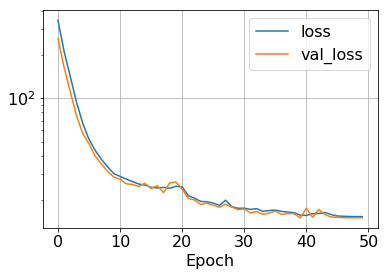

In [19]:
for item in ['loss', 'val_loss']:
    plt.semilogy(np.array(fit_report.history[item][5:]), label=item)
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')

In [20]:
vae.save('last_saved_VAE.h5')

In [21]:
if 0:
    from keras.models import load_model
    vae = load_model('last_saved_VAE.h5')
    print 'Loaded'

# Build encoder and decoder

### Encoder

In [22]:
encoder = Model(inputs=x, outputs=[z_mean, z_log_var])

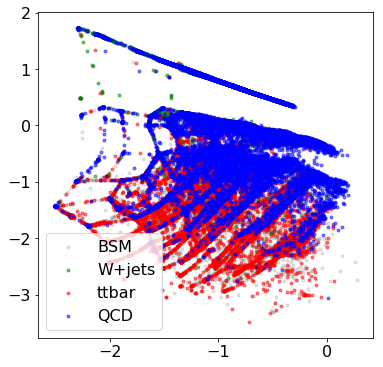

In [23]:
x_val_encoded = np.array(encoder.predict(x_val, batch_size=batch_size))
colors = ['b','r','g','k']
plt.figure(figsize=(6,6))

x_sig_encoded = np.array(encoder.predict(x_sig, batch_size=batch_size))
plt.scatter(x_sig_encoded[0, :, 0], x_sig_encoded[0, :, 1], 
                c='k', marker='.',
               label='BSM', alpha=0.1)

for i in reversed(range(3)):
    cut = l_val == i
    plt.scatter(x_val_encoded[0, :, 0][cut], x_val_encoded[0, :, 1][cut], 
                c=colors[i], marker='.',
               label=samples_name[i], alpha=0.5)

plt.legend(loc='best')
plt.show()

## Probabilistic Decoder

In [24]:
decoder_input = Input(shape=(latent_dim,))
_h1_decoded = decoder_h1(decoder_input)
_h_decoded = decoder_h(_h1_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_log_var = decoder_log_var(_h_decoded)
decoder = Model(decoder_input, [_x_decoded_mean, _x_decoded_log_var])

## Recostruction sum of pdf

In [25]:
def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

IndexError: cannot do a non-empty take from an empty axes.

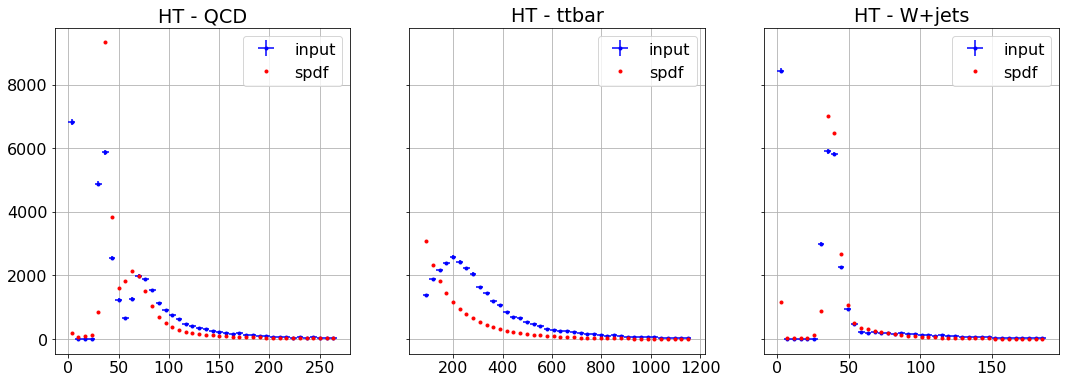

In [26]:
x_autoencoded_pars = vae.predict(x_val)

for i,hlf_name in enumerate(hlf_features):
    f, ax_arr = plt.subplots(1,3, figsize=(18,6), sharey=True)
#     plt.yscale('log', nonposy='clip')
    for k, sample in enumerate(samples_name[:-1]):
        #Plot distribution of the variable
        x_aux = x_val[l_val==k, i]
        histo_range = (np.percentile(x_aux, 5.), np.percentile(x_aux, 99.))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        ax_arr[k].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
        ax_arr[k].grid()
        ax_arr[k].set_title(hlf_name + ' - ' + sample)
        
        if i<12:
            mu_vec = x_autoencoded_pars[0][l_val==k, i]
            sigma_vec = np.exp(x_autoencoded_pars[1][l_val==k, i])
            spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
        else:
            p = 0.5*(1+0.98*np.tanh(x_autoencoded_pars[0][l_val==k, i]))
            
            spdf_bin_content = np.zeros_like(bincenters)
            spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
            spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
            
        ax_arr[k].errorbar(bincenters, spdf_bin_content, fmt='.r', label='spdf')
        
        ax_arr[k].legend(loc='best')
        
plt.show()

# Note for next version:
Change the interpretaion of the parameters that the NN is producing such that distribution differen from gaussian are taken into account.
In particular use discrete distributions for discrete variables.

## Recostruction p-value

In [27]:
x_test = np.concatenate((x_val, x_sig))
l_test = np.concatenate((l_val, 3*np.ones(x_sig.shape[0])))

print x_test.shape
print l_test.shape

(132394, 14)
(132394,)


In [28]:
L_trials = 1
comb_pvalue = []
# for i, x_aux in enumerate(x_test):
#     if i%10000==0: print i
#     x_aux = np.atleast_2d(x_aux)
#     pred = encoder.predict(x_aux)
#     aux_pval = 0
#     for i in range(L_trials):
#         z_aux = np.random.normal(loc=pred[0], scale=np.exp(pred[1]))
#         pred_x = decoder.predict(z_aux)
#         mu = pred_x[0]
#         sigma = np.exp(pred_x[1])
#         x_norm = (x_aux-mu)/sigma
#         pvalue = 1-np.abs(scipy.special.erf(x_norm))/np.sqrt(2)
#         aux_pval += 1-chi2.cdf(-2*np.sum(np.log(pvalue)), 2*pvalue.shape[1])
#     comb_pvalue.append(aux_pval/float(L_trials))

pred_x = vae.predict(x_test)
mu = pred_x[0]
sigma = np.exp(pred_x[1])
p_l2 = 0.5*(1+0.98*np.tanh(mu[:,-2:]))
x_norm = (x_test[:,:-2]-mu[:,:-2])/sigma
pvalue = 1-np.abs(scipy.special.erf(x_norm))/np.sqrt(2)
sum_logp = -2*np.sum(np.log(pvalue), axis=1) 
sum_logp -= 2*np.log(np.where(x_test[:,-2]==1, p_l2[:,0], 1-p_l2[:,0]))
sum_logp -= 2*np.log(np.where(x_test[:,-1]==1, p_l2[:,1], 1-p_l2[:,1]))
comb_pvalue = 1-chi2.cdf(-2*np.sum(np.log(pvalue), axis=1), 2*pvalue.shape[1])

comb_pvalue = np.array(comb_pvalue)

35921.0
30576.0
29976.0
35921.0


Text(0,0.5,u'Number of events')

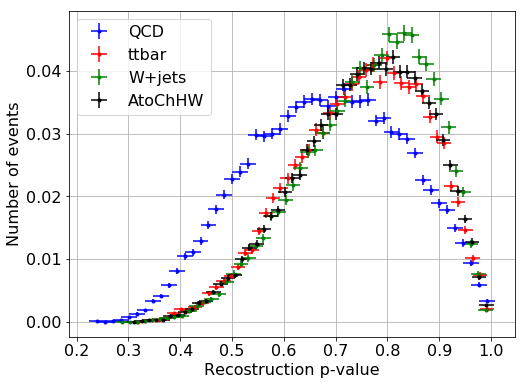

In [29]:
plt.figure(figsize=(8,6))
for i in range(4):
    cut = l_test==i
    bin_content, bin_edges = np.histogram(comb_pvalue[cut], bins=50)
    bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
    area = float(np.sum(bin_content))
    print area
    plt.errorbar(bincenters, bin_content/area, xerr=bin_edges[1]-bin_edges[0], 
                 yerr=np.sqrt(bin_content)/area, fmt='.'+colors[i], label=samples_name[i],)

# plt.yscale('log', nonposy='clip')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Recostruction p-value')
plt.ylabel('Number of events')

In [30]:
l_test

array([0., 0., 0., ..., 3., 3., 3.])

In [31]:
q = np.arange(1,99.9,0.7)
quant_x = np.percentile(comb_pvalue[l_test != 3], q)

In [32]:
sig_p = comb_pvalue[l_test == 3]
norm = sig_p.shape[0]

quant_y = []
for q_aux in quant_x:
    aux = np.sum(sig_p<q_aux)/float(norm)
    quant_y.append(aux)

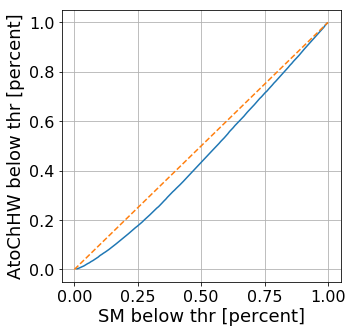

In [33]:
plt.figure(figsize=(5,5))
plt.plot(q*0.01, quant_y)
plt.plot([0,1], [0,1], '--')
plt.xlabel('SM below thr [percent]', fontsize=18)
plt.ylabel('AtoChHW below thr [percent]', fontsize=18)
plt.grid()